In [52]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import datetime
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
dropbox_dir = r'C:/Users/cocoy/Dropbox (Palmer Lab)/Palmer Lab/Shae Ziegler/Suzanne_Mitchell_U01'
df_fits = pd.read_csv(dropbox_dir + '/fits.csv')
df_locomotor = pd.read_csv(dropbox_dir + '/locomotor.csv')
df_wfu = pd.read_csv(dropbox_dir + '/wfu_master.csv')
df_fecal_boli = pd.read_csv(dropbox_dir + '/fecal_boli.csv')

In [16]:
df_fits

,sex,cohort,rfid,coat_color,shipping_box,housing_box,order_in_box,squad_num,box_color,opertant_box,...,expon_adj_R2,expon_AIC,quad_k,quad_R2,quad_adj_R2,quad_AIC,linear_k,linear_R2,linear_adj_R2,linear_AIC
0,m,C02,933000320045751,brown_hood,5,40,2,4,blue,8,...,0.725429,36.342187,0.272698,-1.349954,0.000000,50.562703,6.678471,-0.035885,0.000000,45.647864
1,f,C02,933000320045756,black,11,54,2,5,blue,12,...,0.000000,42.756235,0.259993,-5.508170,0.000000,50.962255,6.338652,-2.516639,0.000000,47.268939
2,f,C02,933000320045757,brown_hood,11,18,2,2,blue,12,...,0.000000,42.401441,0.262557,-4.489528,0.000000,52.609082,6.564409,-2.148642,0.000000,49.273856
3,f,C02,933000320045759,brown_hood,10,52,2,5,blue,8,...,0.920194,32.324584,0.265759,0.378190,0.222737,45.981682,6.163581,0.814850,0.768562,38.712880
4,m,C02,933000320045760,brown,5,39,2,4,blue,6,...,0.879992,35.471797,0.247963,0.533578,0.416973,44.955831,5.690875,0.833890,0.792363,38.761188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,m,C04,933000320047963,black_hood,1,12,2,1,red,8,...,0.378722,39.455651,0.438252,0.506212,0.341616,39.745699,6.498826,0.554768,0.406358,39.228146
391,f,C04,933000320047964,black_hood,6,34,1,3,red,3,...,0.292852,44.912651,0.225828,0.333280,0.166600,45.898297,4.924056,0.460635,0.325794,44.626432
392,m,C04,933000320047968,brown_hood,1,27,1,3,blue,5,...,0.718459,40.902493,0.213945,0.611274,0.514093,44.176931,4.788950,0.761658,0.702073,41.241926
393,m,C04,933000320047973,black,1,12,1,1,red,7,...,0.897968,32.911002,0.222286,0.833993,0.792491,37.170351,4.822055,0.948307,0.935384,30.170114


In [70]:
df_locomotor

,experiment,rfid,cohort,time,file_num,cage,sample,total_distance_x,total_distance_y,horizontal_activity_count,...,ambulatory_episode_peak_average_velocity,ambulatory_episode_median_velocity,left-front_time_legacy,right_front_time_legacy,left_rear_time_legacy,right_rear_time_legacy,margin_time_legacy,center_time_legacy,margin_distance_legacy,center_distance_legacy
0,U01-t1-gp1,933000320045924,C01,t1,gp1,3,120,430.86,468.96,2428,...,295.09,116.97,0.81,68.33,1.22,4.52,673.51,226.50,495.31,648.91
1,U01-t1-gp1,933000320046045,C02,t1,gp1,2,120,1109.68,1270.98,5250,...,447.70,261.87,2.36,8.27,2.16,19.40,346.25,553.76,754.50,2285.09
2,U01-t1-gp1,933000320046058,C01,t1,gp1,1,120,569.60,393.08,4209,...,272.30,177.73,0.00,0.20,7.37,1.57,169.89,730.12,313.14,1100.37
3,U01-t1-gp1,933000320046067,C01,t1,gp1,2,120,618.80,887.75,3748,...,349.34,184.81,4.89,19.55,2.25,10.15,522.49,377.54,723.80,1120.13
4,U01-t1-gp1,933000320046282,C01,t1,gp1,4,120,695.67,538.81,2972,...,257.18,139.19,2.05,17.52,5.40,2.34,232.15,667.88,471.61,1035.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,U01-t2-gp9,933000320047696,C04,t2,gp9,4,120,1233.80,1009.36,5262,...,386.37,285.33,105.93,44.64,239.59,74.24,884.67,15.34,2372.94,363.06
992,U01-t2-gp9,933000320187097,C05,t2,gp9,1,120,1578.30,1335.11,5151,...,444.02,300.89,21.99,20.95,25.19,191.81,723.13,176.87,2113.08,1156.71
993,U01-t2-gp9,933000320187155,C05,t2,gp9,2,120,823.30,562.31,3566,...,379.72,229.02,75.86,14.08,99.88,21.91,814.79,85.23,1257.33,527.50
994,U01-t2-gp9,933000320187194,C05,t2,gp9,3,120,1402.12,1163.00,5598,...,524.11,312.37,54.44,132.28,19.72,37.59,748.97,151.04,2153.31,916.42


In [98]:
#df_fecal_boli['rfid'] = df_fecal_boli.rfid.astype(str)
#df_fecal_boli['rfid'] = df_fecal_boli['rfid'].apply(str)
#df_fecal_boli['rfid'] = pd.Series(df_fecal_boli['rfid'], dtype="string")
#df_fecal_boli['rfid'] = pd.Series(df_fecal_boli['rfid'], dtype=pd.StringDtype)
#df_fecal_boli['rfid'] = df_fecal_boli['rfid'].map(str)
df_fecal_boli['rfid'] = df_fecal_boli['rfid'].values.astype(str)
df_fecal_boli


,rfid,last_5,cohort,box,sex,date_1,time_in_1,fecal_boli_1,date_2,time_in_2,fecal_boli_2,change
0,933000320046058.0,46058.0,C01,1,M,2018-12-20,12:26:00,5,2018-12-21,13:09:00,4.0,-1.0
1,933000320046067.0,46067.0,C01,1,M,2018-12-20,12:26:00,8,2018-12-21,13:09:00,6.0,-2.0
2,933000320046282.0,46282.0,C01,2,M,2018-12-20,12:28:00,11,2018-12-21,13:10:00,7.0,-4.0
3,933000320045924.0,45924.0,C01,2,M,2018-12-20,12:27:00,8,2018-12-21,13:10:00,9.0,1.0
4,933000320046276.0,46276.0,C01,3,M,2018-12-20,12:51:00,5,2018-12-21,13:33:00,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
631,933000320124750.0,24750.0,C07,21,M,2020-10-12,12:42:00,0,2020-10-13,12:43:00,0.0,0.0
632,933000320124693.0,24693.0,C07,23,M,2020-10-12,13:04:00,0,2020-10-13,13:02:00,2.0,2.0
633,933000320124682.0,24682.0,C07,23,M,2020-10-12,13:05:00,3,2020-10-13,13:03:00,2.0,-1.0
634,933000320124669.0,24669.0,C07,24,M,2020-10-12,13:05:00,4,2020-10-13,13:03:00,6.0,2.0


In [54]:
wfu_rfid = df_wfu.last_5.unique()
locomotor_rfid = df_locomotor.rfid.unique()
missmatch = [x for x in wfu_rfid if x not in locomotor_rfid]
print(len(wfu_rfid))
print(len(locomotor_rfid))
len(missmatch)

901
639


264

In [80]:
df_fits_locomotor = pd.merge(df_fits, df_locomotor, on=['rfid','cohort'])
df_wfu_fecal = pd.merge(df_wfu, df_fecal_boli, on=['rfid','cohort'])
df_all = pd.merge(df_wfu_fecal, df_fits_locomotor, on=['rfid','cohort'])
df_all

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

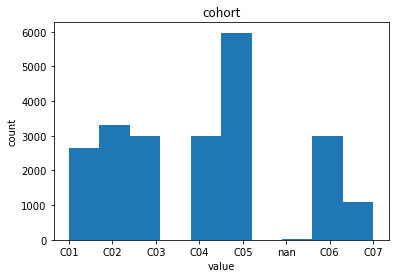